In [1]:
# Adapted from: Chapter 7 and 8 of Deep Learning with Pytorch by Eli Stevens (2020)
try:
    import torch as t
    import torch.nn as tnn
except ImportError:
    print("Colab users: pytorch comes preinstalled. Select Change Ru")
    print("Local users: Please install pytorch for your hardware using instructions from here: https://pytorch.org/get-started/locally/")
    print("ACG users: Please follow instructions here: https://vikasdhiman.info/ECE490-Neural-Networks/posts/0000-00-06-acg-slurm-jupyter/")
    
    raise

if t.cuda.is_available():
    DEVICE="cuda"
    t.cuda.set_device(t.device('cuda:0'))
else:
    DEVICE="cpu"

    
DTYPE = t.get_default_dtype()
print(f"Using {DEVICE=} and {DTYPE=}")

Using DEVICE='cuda' and DTYPE=torch.float32


In [2]:
# imports
import torch.nn
import torch.optim
import torchvision
from torchvision.transforms import Compose, Normalize, Resize
from torchvision.transforms.functional import to_tensor
from torch.utils.data import DataLoader, Dataset
from glob import glob
from PIL import Image
import re
import random
from pathlib import Path

In [3]:

# create a custom dataset for the images
class BiomeDataset(Dataset):
    """
    Dataset for the minecraft biome images
    """
    def __init__(self, data_dir: str, dir_is_paths=False, id_convert_dict=None):
        """
        Arguments:
            data_dir (str): Path to root data directory
            dir_is_paths (bool): If true, interprets data_dir as a list of images
        """
        # init transform to none
        self.transform = None

        if id_convert_dict is not None:
            self.id_to_class = id_convert_dict

        if dir_is_paths:
            self.paths = data_dir
            return
    
        # get the number of images in the dataset
        self.paths = glob(f"{data_dir}/*/*")
        dirs = glob(f"{data_dir}/*")

        self.id_to_class = {} # dictionary which converts a biome id to its class number
        self.data = []  # 2d array. First index indexes biome, second index indexes images
        for i, d in enumerate(dirs):
            self.data.append(glob(f"{d}/*"))
            self.id_to_class[int(re.search(r'[0-9]+', d)[0])] = i

        print(self.id_to_class) 
        print(len(self.id_to_class))   


    def split_data(self, percent_train: float, percent_val: float, seed: int):
        """
        Splits the Dataset per biome into three separate Datasets, 
        one for training, one for validation, and the remainder is for testing.
        """
        train = []
        val = []
        test = []

        rand = random.Random(seed) # TODO: broken af

        # for each biome, randomize the list and then split it
        for b in self.data:
            n_ims = len(b)
            rand.shuffle(b)
            ind1 = int(n_ims * percent_train)
            ind2 = int(n_ims * percent_val)
            train += b[:ind1]
            val += b[ind1:ind2]
            test += b[ind2:]

        return (BiomeDataset(train, dir_is_paths=True, id_convert_dict=self.id_to_class), 
            BiomeDataset(val, dir_is_paths=True, id_convert_dict=self.id_to_class))


    def set_transform(self, transform):
        """
        updates the transform that the dataset will use when transforming images
        """
        self.transform = transform


    def __getitem__(self, idx):
        """
        Returns a tuple of (image: ndarray, label: int)
        """

        imname = self.paths[idx]
        image = Image.open(imname)
        image = to_tensor(image).cuda()  # converts to float tensor
        # apply transforms
        if self.transform is not None:
            image = self.transform(image)
    
        label = int(re.search(r'[0-9]+', imname)[0])
        label = self.id_to_class[label]
        return (image, label)


    def __len__(self):
        return len(self.paths)


all_data = BiomeDataset('../scraping/data')

{27: 0, 164: 1, 21: 2, 155: 3, 11: 4, 15: 5, 156: 6, 50: 7, 4: 8, 25: 9, 39: 10, 44: 11, 32: 12, 16: 13, 34: 14, 13: 15, 35: 16, 3: 17, 6: 18, 131: 19, 37: 20, 7: 21, 23: 22, 22: 23, 17: 24, 160: 25, 158: 26, 18: 27, 0: 28, 45: 29, 31: 30, 29: 31, 157: 32, 28: 33, 163: 34, 132: 35, 26: 36, 33: 37, 1: 38, 12: 39, 162: 40, 130: 41, 36: 42, 19: 43, 140: 44, 129: 45, 5: 46, 30: 47, 166: 48, 38: 49, 134: 50, 133: 51, 161: 52, 2: 53, 10: 54}
55


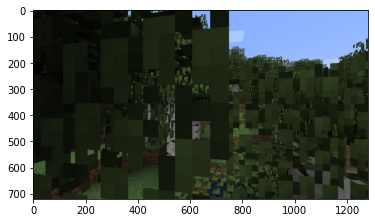

In [5]:
# example image from the dataset
import matplotlib.pyplot as plt
im, label = all_data[3]
plt.imshow(im.cpu().permute(1, 2, 0))

In [8]:
# split up the data
train_data, val_data = all_data.split_data(0.7, 5)
train_data[0][0].shape

torch.Size([3, 649, 1280])

In [9]:
# Normalize the data over each channel
DATA_INFO_FILE = "dataset_info.txt"
if Path(DATA_INFO_FILE).exists():
    print('Loading known dataset information for normalization')
    
    means = torch.Tensor([0, 0, 0])
    std = torch.Tensor([0, 0, 0])
    with open(DATA_INFO_FILE, 'r') as f:
        m = f.readline().replace('\n', '').split(' ')
        means[0] = float(m[0])
        means[1] = float(m[1])
        means[2] = float(m[2])
        s = f.readline().replace('\n', '').split(' ')
        std[0] = float(s[0])
        std[1] = float(s[1])
        std[2] = float(s[2]) 
        print("Loaded means", m)
        print("Loaded std", s)

else:
    # compute the means across each channel for the whole training dataset
    means = torch.Tensor([0, 0, 0])
    for i in range(len(train_data)):
        im = train_data[i][0]
        means += torch.mean(im, dim=[1,2]) 
        if i % 1000 == 0:
            print(f"Calculating dataset means: {i}/{len(train_data)}")

    means = means / i

    print(means)

    # compute the stdev across each channel for the whole training dataset
    sumel = 0.0
    countel = 0
    for i in range(len(train_data)):
        img = train_data[i][0]
        img = (img - means.unsqueeze(1).unsqueeze(1))**2
        sumel += img.sum([1, 2])
        countel += torch.numel(img[0])
        if i % 1000 == 0:
            print(f"Calculating dataset stdevs: {i}/{len(train_data)}")

    std = torch.sqrt(sumel/countel)

    print(std)

    # save dataset info so that it doesn't need to be recalculated
    with open(DATA_INFO_FILE, 'w') as f:
        f.write(f"{means[0]} {means[1]} {means[2]}\n")
        f.write(f"{std[0]} {std[1]} {std[2]}\n")
        
# normalize the training and validation datasets based on the mean and stedv 
# of the training dataset
IMAGE_SIZE = (720//10, 1280//10)
transform_img = Compose([
    Resize(IMAGE_SIZE, antialias=True), # ensure all images are the proper size
    Normalize(mean=means, std=std)
])

train_data.set_transform(transform_img)
val_data.set_transform(transform_img)

Loading known dataset information for normalization
Loaded means ['0.38166487216949463', '0.43992379307746887', '0.4492100179195404']
Loaded std ['0.24501578509807587', '0.27169445157051086', '0.3933259844779968']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


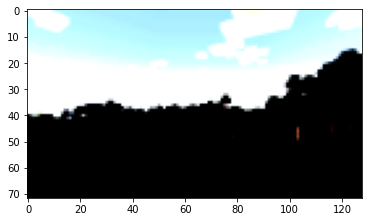

In [10]:
# now a glance at the normalized data. 
im, label = train_data[1]
plt.imshow(im.cpu().permute(1, 2, 0))

In [11]:
# Hyperparameters
batch_size = 128
learning_rate = 1e-3
epochs = 10
momentum = 0.9


# Create the dataloaders
training_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [12]:
# Model definition
loss = torch.nn.CrossEntropyLoss()

class ConvNeuralNet(tnn.Module):
    #  Determine what layers and their order in CNN object
    # Code from https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = tnn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same')
        self.conv_layer2 = tnn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding='same')
        self.max_pool1 = tnn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = tnn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same')
        self.conv_layer4 = tnn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same')
        self.max_pool2 = tnn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = tnn.Linear(9216, 128)
        self.relu1 = tnn.ReLU()
        self.fc2 = tnn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out
model = ConvNeuralNet(55)
model.cuda()

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# check what device model is being stored on
print("Is cuda being used for the model?", all([p.is_cuda for p in model.parameters()]))

Is cuda being used for the model? True


In [13]:
from torch.utils.tensorboard import SummaryWriter
import os, datetime
writer = SummaryWriter()

def loss_and_accuracy(model, loss, validation_dataloader, device=DEVICE):
        # Validation loop
        validation_size = len(validation_dataloader.dataset)
        num_batches = len(validation_dataloader)
        test_loss, correct = 0, 0
        
        with torch.no_grad():
            model.eval() # Put model in eval mode, affects layers like dropout and batchnorm
            for X, y in validation_dataloader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                test_loss += loss(pred, y)
                correct += (pred.argmax(dim=-1) == y).type(DTYPE).sum()

        test_loss /= num_batches
        correct /= validation_size
        return test_loss, correct
    
def train(model, loss, training_dataloader, validation_dataloader, device=DEVICE, chkpt_name='model_ckpt.pt', ignore_chkpt=False):
    model.to(device)
    t0 = 0
    if not ignore_chkpt and os.path.exists(f"runs/{chkpt_name}"):
        checkpoint = torch.load(f"runs/{chkpt_name}")
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        t0 = checkpoint['epoch']
    
    for t in range(t0, epochs):
        # Train loop
        training_size = len(training_dataloader.dataset)
        nbatches = len(training_dataloader)
        model.train() # Put model in train mode, affects layers like dropout and batchnorm
        for batch, (X, y) in enumerate(training_dataloader):
            X = X.to(device)
            y = y.to(device)
            # Compute prediction and loss
            pred = model(X)
            loss_t = loss(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()

            if batch % 1 == 0:
                writer.add_scalar("Train/loss_batch", loss_t,  t*nbatches + batch)
                loss_t, current = loss_t.item(), (batch + 1) * len(X)
                print(f"loss: {loss_t:>7f}  [{current:>5d}/{training_size:>5d}]", end="\r")
                
        writer.add_scalar("Train/loss", loss_t, t)
        valid_loss, correct = loss_and_accuracy(model, loss, validation_dataloader, device=device)
        writer.add_scalar("Valid/loss", valid_loss, t)
        writer.add_scalar("Valid/accuracy", correct, t)
        print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
        if t % 3 == 0:
            torch.save({
                'epoch': t,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, f"runs/{chkpt_name}")
    return model
        
    
print(f"Training model using device {DEVICE}. Started at {datetime.datetime.now()}")
trained_model = train(model, loss, training_dataloader, validation_dataloader, chkpt_name='linear_model_chkpt.pt', ignore_chkpt=True)

test_loss, correct = loss_and_accuracy(model, loss, test_dataloader)
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Training model using device cuda. Started at 2023-04-18 21:14:01.782689


KeyboardInterrupt: 